In [53]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
spark = SparkSession.builder.appName('YelpRec').getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])


In [55]:
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample"
business = spark.read.json(dataDir + "/sample_business")
checkin = spark.read.json(dataDir + "/sample_checkin")
review = spark.read.json(dataDir + "/sample_review")
tip = spark.read.json(dataDir + "/sample_tip")
user = spark.read.json(dataDir + "/sample_user")

In [57]:
business.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|  400 Pasadena Ave S|                null|qkRM_2X51Yqxk3btl...|Synagogues, Relig...|St. Petersburg|{9:0-17:0, 9:0-17...|      1|     27.76659|    -82.732983|      Temple Beth-El|      33707|           5|  3.5|   FL|
|     625 N Stone Ave|{null, null, null...|rBmpy_Y1UbBx8ggHl...|Automotive, Auto ...|        Tucson|{8:0-17:0, 0:0-0:...|      1|   

In [58]:
business.take(1)

[Row(address='400 Pasadena Ave S', attributes=None, business_id='qkRM_2X51Yqxk3btlwAQIg', categories='Synagogues, Religious Organizations', city='St. Petersburg', hours=Row(Friday='9:0-17:0', Monday='9:0-17:0', Saturday=None, Sunday=None, Thursday='9:0-17:0', Tuesday='9:0-17:0', Wednesday='9:0-17:0'), is_open=1, latitude=27.76659, longitude=-82.732983, name='Temple Beth-El', postal_code='33707', review_count=5, stars=3.5, state='FL')]

In [59]:
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

## Recommendation system

In [60]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
df_business = business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_restaurant")

#df_business = df_business.filter((df_business['city'] == 'Toronto') & (df_business.categories.contains('Restaurants'))).drop('city')
df_business = df_business.filter(df_business.categories.contains('Restaurants')).drop('city')

In [62]:
df_review = review.join(df_business, on='business_id', how='inner')

In [63]:
df_review.select(['business_id', 'user_id', 'stars']).show()

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|-sTrihdzACrsOSu1F...|X-amyxsPEkrxDcWpL...|  5.0|
|Mw4IoBY_CXr8oFhbF...|R0Oq3dyj2VkvcYxkM...|  1.0|
|E7RtIisUoRMcADSeb...|sdIiCY-gq-zEZ4csX...|  4.0|
|5dIS6fNq-t5tdj5X5...|AnE2RCheDAYEpFa4H...|  4.0|
|-zbTnIz1zPNPmKpO0...|B8wYdIyXRJIlhIg3W...|  1.0|
|-sTrihdzACrsOSu1F...|ixtKgePFibGVpyMrP...|  4.0|
|RcsTutp1103SGiYta...|W8yhCtI-EGaGqjQuV...|  2.0|
|IkeqRpAUyxNUpVWtd...|XGbLunRUoU26-Y1xo...|  5.0|
|6jr6xW05PcKutwr5l...|PU4CsfSvXnG559wqu...|  1.0|
|9N-XAq_LjfCXL2tFp...|AWWU9FXm0bJwH5agt...|  5.0|
|JpwG8sDNsHuD0f6NF...|3fjbxeeDGgw-F2fGl...|  1.0|
|Fzrpwup-gVia-806_...|8yNP6rZzE6MFSsp3U...|  4.0|
|X6ry8WkgUyBNPpNxI...|7fZu8ud7JXFthU0jP...|  4.0|
|mYMPepp0QIZRk_52p...|Br7NfAxcRprDceabs...|  5.0|
|tW85sx5fr8-gCTCOi...|ziHe7d_nfbNF7Aw9n...|  4.0|
|dzeBiAu0VAaVBbMwc...|dLPfEyd94_FGSIS76...|  1.0|
|kVTHnhgYUw-Pmr7wg...|fMg591KP-lXkzQw0u...|  4.0|


In [64]:
df_review.count()

44912

In [65]:
df_review.take(1)

[Row(business_id='-sTrihdzACrsOSu1FYdfxQ', cool=1, date='2018-10-18 18:11:16', funny=0, review_id='DgQxyDqE0wfvHFCJN_G11g', stars=5.0, text='Look Down! A groovy below-street-level Mediterranean diner.\nSeriously the Best Matzo Ball Soup I have ever had! It is called Yemenite Matzo Ball Soup and it has hints of Turmeric and Cumin in the flavor as well as chunks of roasted chicken. Maya is light and buttery! \nThe sandwiches could last you all day too.\nA really generous portion on every plate with fresh thick cut bread or a soft challah roll.', useful=1, user_id='X-amyxsPEkrxDcWpLD065A', name='The Rooster', stars_restaurant=4.5, review_count=266, attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol="u'full_bar'", Ambience="{'touristy': False, 'hipster': True, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': True, 'upscale': False, 'classy': False, 'casual': True}", BYOB=None, BYOBCorkage=None, BestNights="{'monday': False, 'tuesday': False, 'friday': True, 'wed

In [66]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- stars_restaurant: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = 

In [67]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_review).transform(df_review)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

DataFrame[business_id: string, user_id: string, business_id_index: double, user_id_index: double]

In [68]:
transformed.show(5)

23/08/07 20:37:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1988.1 KiB


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+----------------+------------+--------------------+--------------------+-----------------+-------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|                name|stars_restaurant|review_count|          attributes|          categories|business_id_index|user_id_index|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+--------------------+----------------+------------+--------------------+--------------------+-----------------+-------------+
|-sTrihdzACrsOSu1F...|   1|2018-10-18 18:11:16|    0|DgQxyDqE0wfvHFCJN...|  5.0|Look Down! A groo...|     1|X-amyxsPEkrxDcWpL...|         The Rooster|             4.5|         266|{null, null, u'fu...|Restaurants, Cock...|            2

In [69]:
(training, test) = transformed.randomSplit([0.8, 0.2])

In [70]:
als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model=als.fit(training)

23/08/07 20:37:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2025.0 KiB
23/08/07 20:37:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2028.3 KiB
23/08/07 20:37:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2029.8 KiB
23/08/07 20:37:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2031.0 KiB
23/08/07 20:37:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2030.0 KiB
23/08/07 20:37:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2031.3 KiB
23/08/07 20:37:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2032.0 KiB
23/08/07 20:37:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2035.1 KiB
23/08/07 20:37:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [72]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")

In [73]:
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

23/08/07 20:38:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/07 20:38:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/08/07 20:38:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


RMSE=2.362234338414523


23/08/07 20:38:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


In [75]:
test = model.recommendForAllUsers(20).filter(col('user_id_index')==30).select("recommendations").collect()
topRestaurants = []
for item in test[0][0]:        
    topRestaurants.append(item.business_id_index)
    
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")

23/08/07 20:41:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/07 20:41:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


In [76]:
transformed.select(['business_id', 'user_id', 'stars', 'categories'])\
.filter(col('user_id_index')==30)\
.show()


23/08/07 20:41:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1740.9 KiB
23/08/07 20:41:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1740.9 KiB
23/08/07 20:41:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1740.9 KiB


+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|stars|          categories|
+--------------------+--------------------+-----+--------------------+
|EfJ-1C8PH9TpGTskF...|SXeMGP5lNgc03z7cl...|  4.0|Whiskey Bars, Pub...|
|4SRl5od0lY33oK1GM...|SXeMGP5lNgc03z7cl...|  4.0|Restaurants, Amer...|
|qTicP3qlsW6zqLV7P...|SXeMGP5lNgc03z7cl...|  2.0|Restaurants, Asia...|
|ga3gRASr7Jc_WK--E...|SXeMGP5lNgc03z7cl...|  3.0|Tex-Mex, American...|
|4YoVUmkpUBNtdYa80...|SXeMGP5lNgc03z7cl...|  1.0|Restaurants, Nigh...|
|woF39W2-DHBbqKSab...|SXeMGP5lNgc03z7cl...|  3.0|American (New), F...|
|zRrxC7NDkgoDKN55B...|SXeMGP5lNgc03z7cl...|  3.0|Beer, Wine & Spir...|
+--------------------+--------------------+-----+--------------------+



In [77]:
restaurants.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'categories', 'name'])\
.drop_duplicates(subset=['name'])\
.show()

+--------------------+-----+--------------------+--------------------+
|         business_id|stars|          categories|                name|
+--------------------+-----+--------------------+--------------------+
|M9vIGIzv7OuRtaRgr...|  4.0|Nightlife, Restau...|Sanders Ferry Piz...|
|T_Qj3xR1CrZZhIo3e...|  5.0|Sandwiches, Hot D...|The Picnic Tap Hu...|
|SA1kBystZZn8yYiQs...|  4.0|Restaurants, Amer...|         Cafe Chorba|
|3KUACt6r8syRa1t0d...|  5.0|Sandwiches, Break...|           Mini Mart|
|pt5huZn_qmSi-4ISW...|  5.0|Restaurants, Pan ...|Thai Kitchen - Fl...|
|v-hlpEd6gQ5N9q0WV...|  5.0| Indian, Restaurants|Delhi Palace Rest...|
|AXp_lasFH0Nbnz6-B...|  5.0|Latin American, R...|            La Choza|
|iiAbYMzeNhI9DZzlm...|  5.0|Greek, Restaurant...|               Petos|
|oQ5vMDu5GihRMLCsy...|  4.0|Vegan, Salad, Aca...|Clean Juice Wynne...|
|EFXzJHBY3rCKDRUwR...|  5.0|Restaurants, Wrap...|Karachi Kabab & G...|
|MBBYCVzoQjNYaDlLj...|  4.0|Mexican, Restaura...|         Taqueria DF|
|Qm5px

In [79]:
restaurants.printSchema()

root
 |-- business_id_index: integer (nullable = true)



In [80]:
transformed.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- stars_restaurant: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = 

In [83]:
restaurant_categories = transformed.select('categories').filter(col('user_id_index')==30).collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]

23/08/07 20:48:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1740.1 KiB


In [84]:
text = " ".join(review for review in restaurant_categories_list)

In [86]:
#pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/5d/6b/011c4470fde93e2bfbe4cc1012077f6b96030124e3cd069b5500ad6e8b69/wordcloud-1.9.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.3/461.3 kB 9.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


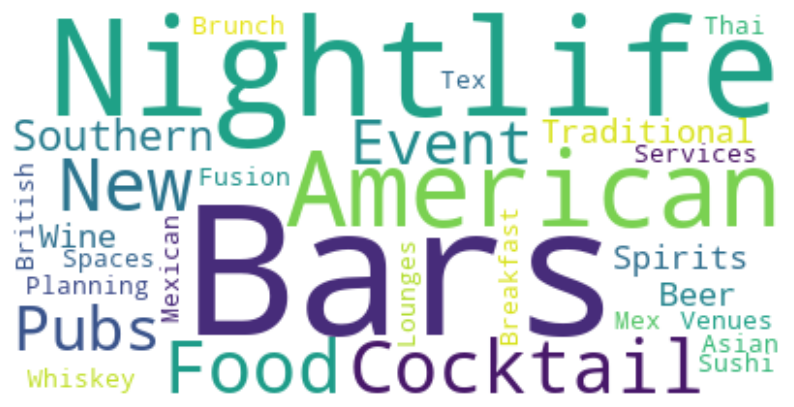

In [87]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()